In [1]:
total_files = 60
#Fabric Spark expect the path in this format
raw_landing='/lakehouse/default/Files/something'

***Check if Fabric running***

In [2]:
# @title
## if running inside Fabric, it will skip Spark installation
try:
    mssparkutils
except NameError:
    mssparkutils = None

***Install Package***

In [3]:
!pip install   duckdb --upgrade
!pip install   polars --upgrade
!pip install   'ibis-framework' --pre --upgrade
!pip install   deltalake

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.5/18.5 MB 34.8 MB/s eta 0:00:00
  Attempting uninstall: duckdb
    Found existing installation: duckdb 0.10.2
    Uninstalling duckdb-0.10.2:
      Successfully uninstalled duckdb-0.10.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 28.3/28.3 MB 14.3 MB/s eta 0:00:00
  Attempting uninstall: polars
    Found existing installation: polars 0.20.2
    Uninstalling polars-0.20.2:
      Successfully uninstalled polars-0.20.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 7.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.1/399.1 kB 31.1 MB/s eta 0:00:00
  Attempting uninstall: sqlglot
    Found existing installation: sqlglot 20.11.0
    Uninstalling sqlglot-20.11.0:
      Successfully uninstalled sqlglot-20.11.0
  Attempting uninstall: ibis-framework
    Found existing installation: ibis-framework 8.0.0
    Uninstalling ibis-framework-8.0.0:
      Successfully uninstalled ibis-framework-8.0.0
ERROR: pip's dependen

In [4]:
if mssparkutils is None:
 !pip install -q delta-spark
 import pyspark
 from delta import *
 builder = pyspark.sql.SparkSession.builder.appName("MyApp") \
    .config("spark.sql.extensions", "io.delta.sql.DeltaSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.delta.catalog.DeltaCatalog")
 spark = configure_spark_with_delta_pip(builder).getOrCreate()
 spark.conf.set("spark.sql.execution.arrow.enabled", "true")
else:
 print('You are in Fabric, all good, no need to install Spark')


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [5]:
# @title
from psutil import *
core = cpu_count()
vCPU = str(core) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
print(vCPU +' Memory:'+ str(mem))

2 vCPU Memory:13.0


# Download Data

In [6]:
# @title
import re ,os
import requests
from urllib.request import urlopen
def download(url,Path):
    if not os.path.exists(Path):
      os.makedirs(Path, exist_ok=True)
    result = urlopen(url).read().decode('utf-8')
    pattern = re.compile(r'[\w.]*.zip')
    filelist1 = pattern.findall(result)
    filelist_unique = list(set(filelist1))[:total_files]
    print(str(len(filelist_unique)) + ' New File Loaded')
    if len(filelist_unique) != 0 :
      for x in filelist_unique:
           with requests.get(url+x, stream=True) as resp:
            if resp.ok:
              with open(f"{Path}/{x}", "wb") as f:
               for chunk in resp.iter_content(chunk_size=4096):
                f.write(chunk)
    return "done"

In [7]:
# @title
from shutil import unpack_archive
import os , glob
def unzip(Source, Destination):
    filelist=[os.path.basename(x) for x in glob.glob(Source+'*.zip')]
    for x in filelist:
          try:
            unpack_archive(str(Source+x), str(Destination), 'zip')
          except:
            pass
    return "done"

In [8]:
download("https://nemweb.com.au/Reports/Current/Daily_Reports/",raw_landing+"/zip/")
unzip(raw_landing+"/zip/",raw_landing+"/csv/")

60 New File Loaded


'done'

# DuckDB

In [9]:
# @title
import duckdb
def duckdb_clean_csv(x):
	raw =duckdb.sql(F"""from read_csv({x},
	Skip=1,header =0,all_varchar=1,
	columns={{
	'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
	'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
	'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
	'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
	'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
	'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
	'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
	'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
	'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
	'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
	'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
	'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
	'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
	'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
	'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
	'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'
	}},
	filename =1,null_padding = true,ignore_errors=1,auto_detect=false)
	where I='D' and UNIT ='DUNIT' AND VERSION = 3                  """)
	columns = list(set(raw.columns) - {'SETTLEMENTDATE','DUID','I','filename','UNIT'})
	exprs = [
		duckdb.ColumnExpression(x).cast(duckdb.typing.DOUBLE).alias(x)
		for x in columns
	         ]
	rel2 = raw.select('SETTLEMENTDATE','DUID','I','filename','UNIT',*exprs)

	scada=duckdb.sql(""" select *exclude(SETTLEMENTDATE,I,XX,filename),cast (SETTLEMENTDATE as TIMESTAMPTZ) as SETTLEMENTDATE,
	isoyear (cast (SETTLEMENTDATE as timestamp)) as YEAR  from rel2  """)
	return scada.arrow()


# Polars

In [10]:
# @title
import polars as pl
def polars_clean_csv(x):
  schema ={'I': pl.String,'UNIT': pl.String,'XX': pl.String,'VERSION': pl.String,'SETTLEMENTDATE': pl.String,'RUNNO': pl.String,
    'DUID': pl.String,'INTERVENTION': pl.String,'DISPATCHMODE': pl.String,'AGCSTATUS': pl.String,'INITIALMW': pl.String,
    'TOTALCLEARED': pl.String,'RAMPDOWNRATE': pl.String,'RAMPUPRATE': pl.String,'LOWER5MIN': pl.String,
    'LOWER60SEC': pl.String,'LOWER6SEC': pl.String,'RAISE5MIN': pl.String,'RAISE60SEC': pl.String,
    'RAISE6SEC': pl.String,'MARGINAL5MINVALUE': pl.String,'MARGINAL60SECVALUE': pl.String,
    'MARGINAL6SECVALUE': pl.String,'MARGINALVALUE': pl.String,'VIOLATION5MINDEGREE': pl.String,
    'VIOLATION60SECDEGREE': pl.String,'VIOLATION6SECDEGREE': pl.String,'VIOLATIONDEGREE': pl.String,
    'LOWERREG': pl.String,'RAISEREG': pl.String,'AVAILABILITY': pl.String,'RAISE6SECFLAGS': pl.String,
    'RAISE60SECFLAGS': pl.String,'RAISE5MINFLAGS': pl.String,'RAISEREGFLAGS': pl.String,
    'LOWER6SECFLAGS': pl.String,'LOWER60SECFLAGS': pl.String,'LOWER5MINFLAGS': pl.String,
    'LOWERREGFLAGS': pl.String,'RAISEREGAVAILABILITY': pl.String,'RAISEREGENABLEMENTMAX': pl.String,
    'RAISEREGENABLEMENTMIN': pl.String,'LOWERREGAVAILABILITY': pl.String,'LOWERREGENABLEMENTMAX': pl.String,
    'LOWERREGENABLEMENTMIN': pl.String,'RAISE6SECACTUALAVAILABILITY': pl.String,
    'RAISE60SECACTUALAVAILABILITY': pl.String,'RAISE5MINACTUALAVAILABILITY': pl.String,
    'RAISEREGACTUALAVAILABILITY': pl.String,'LOWER6SECACTUALAVAILABILITY': pl.String,
    'LOWER60SECACTUALAVAILABILITY': pl.String,'LOWER5MINACTUALAVAILABILITY': pl.String,'LOWERREGACTUALAVAILABILITY': pl.String}
  raw = pl.scan_csv(x,
                    skip_rows=1,
                    schema=schema,
                    has_header=False,
                    truncate_ragged_lines=True)
  transform =(
      raw
      .filter(pl.col("I")=='D')
      .filter(pl.col("UNIT")=='DUNIT')
      .filter(pl.col("VERSION")=='3')
      .drop("XX")
      .drop("I")
  )
  z = transform.with_columns(pl.col("SETTLEMENTDATE").str.to_datetime())
  columns = list(set(transform.columns) - {'SETTLEMENTDATE','DUID','UNIT'})
  final=z.with_columns(pl.col(columns).cast(pl.Float64),YEAR=pl.col("SETTLEMENTDATE").dt.iso_year()).collect()
  return final.to_arrow()

# Pandas

In [11]:
import pandas as pd

def Pandas_clean_csv(chunk):
    appended_data = []
    for filename in chunk:
        # Read only necessary columns
        df = pd.read_csv(filename, skiprows=1,dtype=str, names=range(131), keep_default_na=False,  index_col=False)
        df = df.iloc[:, :53]
        df = df.rename(columns={1: 'DISPATCH', 3: 'VERSION'}).query('DISPATCH=="DUNIT" and VERSION=="3"')
        df.columns = df.iloc[0]
        df = df[1:]
        df = df.rename(columns={'3': 'version', 'DUNIT': 'UNIT'})
        df = df.drop(columns=['I'])
        df.drop([""], axis=1, inplace=True)
        df['SETTLEMENTDATE'] = pd.to_datetime(df['SETTLEMENTDATE'])
        columns = list(set(df.columns) - {'SETTLEMENTDATE', 'DUID', 'UNIT'})
        df[columns] = df[columns].apply(pd.to_numeric, errors='coerce', dtype_backend='pyarrow')
        df['YEAR'] = df['SETTLEMENTDATE'].dt.year
        appended_data.append(df)
    appended_data = pd.concat(appended_data, ignore_index=True)
    return appended_data

# Spark

In [12]:
# @title
from pyspark.sql import functions as f
def spark_clean_csv(files_to_upload_full_Path):
 user_schema="""
 I  STRING,UNIT  STRING,XX  STRING,VERSION  STRING,SETTLEMENTDATE  STRING,RUNNO  STRING,DUID  STRING,
 INTERVENTION  STRING,DISPATCHMODE  STRING,AGCSTATUS  STRING,INITIALMW  STRING,TOTALCLEARED  STRING,RAMPDOWNRATE  STRING,
 RAMPUPRATE  STRING,LOWER5MIN  STRING,LOWER60SEC  STRING,LOWER6SEC  STRING,RAISE5MIN  STRING,RAISE60SEC  STRING,RAISE6SEC  STRING,
 MARGINAL5MINVALUE  STRING,MARGINAL60SECVALUE  STRING,MARGINAL6SECVALUE  STRING,MARGINALVALUE  STRING,VIOLATION5MINDEGREE  STRING,
 VIOLATION60SECDEGREE  STRING,VIOLATION6SECDEGREE  STRING,VIOLATIONDEGREE  STRING,LOWERREG  STRING,RAISEREG  STRING,AVAILABILITY  STRING,
 RAISE6SECFLAGS  STRING,RAISE60SECFLAGS  STRING,RAISE5MINFLAGS  STRING,RAISEREGFLAGS  STRING,LOWER6SECFLAGS  STRING,LOWER60SECFLAGS STRING,
 LOWER5MINFLAGS  STRING,LOWERREGFLAGS  STRING,RAISEREGAVAILABILITY  STRING,RAISEREGENABLEMENTMAX  STRING,RAISEREGENABLEMENTMIN  STRING,
 LOWERREGAVAILABILITY  STRING,LOWERREGENABLEMENTMAX  STRING,LOWERREGENABLEMENTMIN  STRING,RAISE6SECACTUALAVAILABILITY  STRING,
 RAISE60SECACTUALAVAILABILITY  STRING,RAISE5MINACTUALAVAILABILITY  STRING,RAISEREGACTUALAVAILABILITY  STRING,
 LOWER6SECACTUALAVAILABILITY  STRING,LOWER60SECACTUALAVAILABILITY  STRING,LOWER5MINACTUALAVAILABILITY  STRING,
 LOWERREGACTUALAVAILABILITY  STRING
 """
 df = spark.read.format("csv")\
     .option("header","true") \
     .schema(user_schema)\
     .load(files_to_upload_full_Path)\
     .filter("unit='DUNIT' and version =3 and I='D'")\
     .drop('xx')\
     .drop('I')\
     .withColumn('SETTLEMENTDATE',f.to_timestamp('SETTLEMENTDATE','yyyy/MM/dd HH:mm:ss'))\
     .withColumn("file", f.regexp_extract(f.input_file_name(), r"Daily_Reports\/([^\W'\.']+\.CSV)", 1))\
     .withColumn("PRIORITY", f.lit(1))
 df_cols = list(set(df.columns) - {'SETTLEMENTDATE','DUID','file','UNIT','transactionId','PRIORITY'})
 for col_name in df_cols:
    df = df.withColumn(col_name, f.col(col_name).cast('double'))
 df = df.withColumn('DATE', f.to_date(f.col('SETTLEMENTDATE')))\
      .withColumn('YEAR', f.year(f.col('SETTLEMENTDATE')))
 return df

# Ibis

In [13]:
# @title
import ibis
def ibis_clean_csv(files_to_upload_full_Path):
 schema={
			'I': 'VARCHAR','UNIT': 'VARCHAR','XX': 'VARCHAR','VERSION': 'VARCHAR','SETTLEMENTDATE': 'VARCHAR','RUNNO': 'VARCHAR',
			'DUID': 'VARCHAR','INTERVENTION': 'VARCHAR','DISPATCHMODE': 'VARCHAR','AGCSTATUS': 'VARCHAR','INITIALMW': 'VARCHAR',
			'TOTALCLEARED': 'VARCHAR','RAMPDOWNRATE': 'VARCHAR','RAMPUPRATE': 'VARCHAR','LOWER5MIN': 'VARCHAR',
			'LOWER60SEC': 'VARCHAR','LOWER6SEC': 'VARCHAR','RAISE5MIN': 'VARCHAR','RAISE60SEC': 'VARCHAR',
			'RAISE6SEC': 'VARCHAR','MARGINAL5MINVALUE': 'VARCHAR','MARGINAL60SECVALUE': 'VARCHAR',
			'MARGINAL6SECVALUE': 'VARCHAR','MARGINALVALUE': 'VARCHAR','VIOLATION5MINDEGREE': 'VARCHAR',
			'VIOLATION60SECDEGREE': 'VARCHAR','VIOLATION6SECDEGREE': 'VARCHAR','VIOLATIONDEGREE': 'VARCHAR',
			'LOWERREG': 'VARCHAR','RAISEREG': 'VARCHAR','AVAILABILITY': 'VARCHAR','RAISE6SECFLAGS': 'VARCHAR',
			'RAISE60SECFLAGS': 'VARCHAR','RAISE5MINFLAGS': 'VARCHAR','RAISEREGFLAGS': 'VARCHAR',
			'LOWER6SECFLAGS': 'VARCHAR','LOWER60SECFLAGS': 'VARCHAR','LOWER5MINFLAGS': 'VARCHAR',
			'LOWERREGFLAGS': 'VARCHAR','RAISEREGAVAILABILITY': 'VARCHAR','RAISEREGENABLEMENTMAX': 'VARCHAR',
			'RAISEREGENABLEMENTMIN': 'VARCHAR','LOWERREGAVAILABILITY': 'VARCHAR','LOWERREGENABLEMENTMAX': 'VARCHAR',
			'LOWERREGENABLEMENTMIN': 'VARCHAR','RAISE6SECACTUALAVAILABILITY': 'VARCHAR',
			'RAISE60SECACTUALAVAILABILITY': 'VARCHAR','RAISE5MINACTUALAVAILABILITY': 'VARCHAR',
			'RAISEREGACTUALAVAILABILITY': 'VARCHAR','LOWER6SECACTUALAVAILABILITY': 'VARCHAR',
			'LOWER60SECACTUALAVAILABILITY': 'VARCHAR','LOWER5MINACTUALAVAILABILITY': 'VARCHAR','LOWERREGACTUALAVAILABILITY': 'VARCHAR'}
 raw = ibis.read_csv(files_to_upload_full_Path,Skip=1,header =0,all_varchar=1,columns =schema,filename =1,null_padding = 1,ignore_errors=1,auto_detect=0)
 DUNIT = raw.filter((raw.UNIT == "DUNIT") & (raw.VERSION  == '3') & (raw.I  == 'D')).drop("XX","I")
 DUNIT = DUNIT.cast({"SETTLEMENTDATE": "timestamp"})
 DUNIT = DUNIT.mutate(
      date=DUNIT.SETTLEMENTDATE.cast("date"),
      year=DUNIT.SETTLEMENTDATE.year(),
  )
 df_cols = list(set(DUNIT.columns) - {'SETTLEMENTDATE','DUID','filename','UNIT','date','year'})
 for col_name in df_cols:
      DUNIT = DUNIT.cast({col_name: "double"})
 return DUNIT

# Pyarrow

In [14]:
# work in Progress
from pyarrow import csv
import pyarrow.compute as pc
import pyarrow as pa
import pyarrow.dataset as ds
def pyarrow_clean_csv(files_to_upload_full_Path):
  new_schema = pa.schema([
  ('I', pa.string()),  ('UNIT', pa.string()),  ('XX', pa.string()),  ('VERSION', pa.float64()),  ('SETTLEMENTDATE', pa.string()),  ('RUNNO', pa.float64()),  ('DUID', pa.string()),  ('INTERVENTION', pa.float64()),
  ('DISPATCHMODE', pa.float64()),  ('AGCSTATUS', pa.float64()),  ('INITIALMW', pa.float64()),  ('TOTALCLEARED', pa.float64()),  ('RAMPDOWNRATE', pa.float64()),  ('RAMPUPRATE', pa.float64()),  ('LOWER5MIN', pa.float64()),
  ('LOWER60SEC', pa.float64()),  ('LOWER6SEC', pa.float64()),  ('RAISE5MIN', pa.float64()),  ('RAISE60SEC', pa.float64()),  ('RAISE6SEC', pa.float64()),  ('MARGINAL5MINVALUE', pa.float64()),  ('MARGINAL60SECVALUE', pa.float64()),
  ('MARGINAL6SECVALUE', pa.float64()),  ('MARGINALVALUE', pa.float64()),  ('VIOLATION5MINDEGREE', pa.float64()),  ('VIOLATION60SECDEGREE', pa.float64()),  ('VIOLATION6SECDEGREE', pa.float64()),  ('VIOLATIONDEGREE', pa.float64()),
  ('LOWERREG', pa.float64()),  ('RAISEREG', pa.float64()),  ('AVAILABILITY', pa.float64()),  ('RAISE6SECFLAGS', pa.float64()),  ('RAISE60SECFLAGS', pa.float64()),  ('RAISE5MINFLAGS', pa.float64()),
  ('RAISEREGFLAGS', pa.float64()),  ('LOWER6SECFLAGS', pa.float64()),  ('LOWER60SECFLAGS', pa.float64()),  ('LOWER5MINFLAGS', pa.float64()),  ('LOWERREGFLAGS', pa.float64()),  ('RAISEREGAVAILABILITY', pa.float64()),
  ('RAISEREGENABLEMENTMAX', pa.float64()),  ('RAISEREGENABLEMENTMIN', pa.float64()),  ('LOWERREGAVAILABILITY', pa.float64()),  ('LOWERREGENABLEMENTMAX', pa.float64()),  ('LOWERREGENABLEMENTMIN', pa.float64()),
  ('RAISE6SECACTUALAVAILABILITY', pa.float64()),  ('RAISE60SECACTUALAVAILABILITY', pa.float64()),  ('RAISE5MINACTUALAVAILABILITY', pa.float64()),  ('RAISEREGACTUALAVAILABILITY', pa.float64()),  ('LOWER6SECACTUALAVAILABILITY', pa.float64()),
  ('LOWER60SECACTUALAVAILABILITY', pa.float64()),  ('LOWER5MINACTUALAVAILABILITY', pa.float64()),  ('LOWERREGACTUALAVAILABILITY', pa.float64()),
    ])
  ReadOptions = csv.ReadOptions(column_names=new_schema.names,skip_rows=1)
  ParseOptions  = csv.ParseOptions(invalid_row_handler=lambda i: "skip")
  ConvertOptions = csv.ConvertOptions(strings_can_be_null=True)
  format = ds.CsvFileFormat(parse_options = ParseOptions ,convert_options = ConvertOptions ,read_options = ReadOptions  )
  raw = ds.dataset(files_to_upload_full_Path, format =format)
  df= raw.filter((pc.field('I') == 'D') & (pc.field('UNIT') == 'DUNIT') & (pc.field('VERSION') == 3)).to_table().cast(new_schema)
  df= df.drop_columns(['I','XX'])
  df = df.set_column(df.schema.get_field_index("SETTLEMENTDATE"), "SETTLEMENTDATE",pc.strptime(df['SETTLEMENTDATE'], format="%Y/%m/%d %H:%M:%S", unit='s').cast(pa.timestamp("s")))
  df = df.add_column(0,"YEAR", pc.year(df['SETTLEMENTDATE']))
  return df

# Transformation

In [15]:
# @title
import glob,os
Source = raw_landing+"/csv/"
list_files=[os.path.basename(x) for x in glob.glob(Source+'*.CSV')]
files_to_upload_full_Path = [Source + i for i in list_files][:total_files]

In [16]:
# maximum nbr pf files is 60, you can customize how many files to process at one time, RAM is the bottlneck
import time
results = pd.DataFrame(columns=['Engine','step','duration'])

In [17]:
%%time
### adjust Path for Fabric
if mssparkutils is None:
  files_to_upload_full_Path_spark = files_to_upload_full_Path
  table_Path= "/lakehouse/default/Tables/scada_spark"
else:
  files_to_upload_full_Path_spark = [w.replace('/lakehouse/default/', '') for w in files_to_upload_full_Path]
  table_Path= "Tables/scada_spark"
chunk_len = total_files
if len(files_to_upload_full_Path_spark) >0 :
  for i in range(0, len(files_to_upload_full_Path_spark), chunk_len):
    chunk = files_to_upload_full_Path_spark[i:i + chunk_len]
    ##########################
    start = time.time()
    df = spark_clean_csv(chunk)
    df.write.mode("append").format("delta").partitionBy("year").save(table_Path)
    del df
    print('Spark total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Spark',i,time.time()-start]], columns=results.columns), results])

Spark total:468.4011142253876
CPU times: user 3.1 s, sys: 425 ms, total: 3.52 s
Wall time: 7min 48s


In [18]:
%%time
from deltalake.writer import write_deltalake
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= pyarrow_clean_csv(chunk)
    print('Pyarrow read CSV:' + str(time.time()-start))
    write_deltalake("/lakehouse/default/Tables/scada_Pyarrow",df, mode="append",partition_by=['YEAR'], storage_options={"allow_unsafe_rename":"true"})
    print('Pyarrow total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Pyarrow',i,time.time()-start]], columns=results.columns), results])

Pyarrow read CSV:95.03547143936157
Pyarrow total:114.21434330940247
CPU times: user 1min 55s, sys: 42.7 s, total: 2min 37s
Wall time: 1min 54s


In [19]:
%%time
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df = ibis_clean_csv(chunk)
    df.to_delta("/lakehouse/default/Tables/scada_ibis",mode="append",partition_by=['year'],storage_options={"allow_unsafe_rename":"true"})
    del df
    print('Ibis total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Ibis',i,time.time()-start]], columns=results.columns), results])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

Ibis total:153.58814573287964
CPU times: user 3min 46s, sys: 17.8 s, total: 4min 3s
Wall time: 2min 33s


In [20]:
%%time
from deltalake.writer import write_deltalake
chunk_len = total_files
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= duckdb_clean_csv(chunk)
    print('duckdb read CSV:' + str(time.time()-start))
    write_deltalake("/lakehouse/default/Tables/scada_DuckDB",df, mode="append", partition_by=['YEAR'],storage_options={"allow_unsafe_rename":"true"})
    del df
    print('DuckDB total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['DuckDB',i,time.time()-start]], columns=results.columns), results])

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

duckdb read CSV:73.21629571914673
DuckDB total:90.23613810539246
CPU times: user 2min 1s, sys: 19.5 s, total: 2min 20s
Wall time: 1min 30s


In [21]:
%%time
if mem > 13:
 chunk_len = total_files
else:
  chunk_len = 20
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ##########################
    start = time.time()
    df= polars_clean_csv(chunk)
    print('polars read CSV:' + str(time.time()-start))
    write_deltalake("/lakehouse/default/Tables/scada_Polars",df, mode="append", partition_by=['YEAR'],storage_options={"allow_unsafe_rename":"true"})
    del df
    print('Polars total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Polars',i,time.time()-start]], columns=results.columns), results])

polars read CSV:58.21408486366272
Polars total:78.63413071632385
polars read CSV:65.81471824645996
Polars total:91.3344213962555
polars read CSV:65.47630453109741
Polars total:92.10404968261719
CPU times: user 5min 49s, sys: 33.6 s, total: 6min 22s
Wall time: 4min 22s


In [22]:
%%time
import pyarrow as pa
if mem > 13:
 chunk_len = total_files
else:
  chunk_len = 20
if len(files_to_upload_full_Path) >0 :
  for i in range(0, len(files_to_upload_full_Path), chunk_len):
    chunk = files_to_upload_full_Path[i:i + chunk_len]
    ########################## make sure to ignore index
    start = time.time()
    df= Pandas_clean_csv(chunk)
    xx= pa.Table.from_pandas(df,preserve_index=False)
    print('Pandas read CSV:' + str(time.time()-start))
    write_deltalake("/lakehouse/default/Tables/scada_Pandas",xx, mode="append", partition_by=['YEAR'],storage_options={"allow_unsafe_rename":"true"})
    del xx
    print('Pandas total:' + str(time.time()-start))
    results = pd.concat([pd.DataFrame([['Pandas',i,time.time()-start]], columns=results.columns), results])

Pandas read CSV:234.70519638061523
Pandas total:240.13053679466248
Pandas read CSV:228.73556089401245
Pandas total:234.24643421173096
Pandas read CSV:226.56128525733948
Pandas total:232.29727935791016
CPU times: user 10min 18s, sys: 1min 20s, total: 11min 38s
Wall time: 11min 46s


# Results

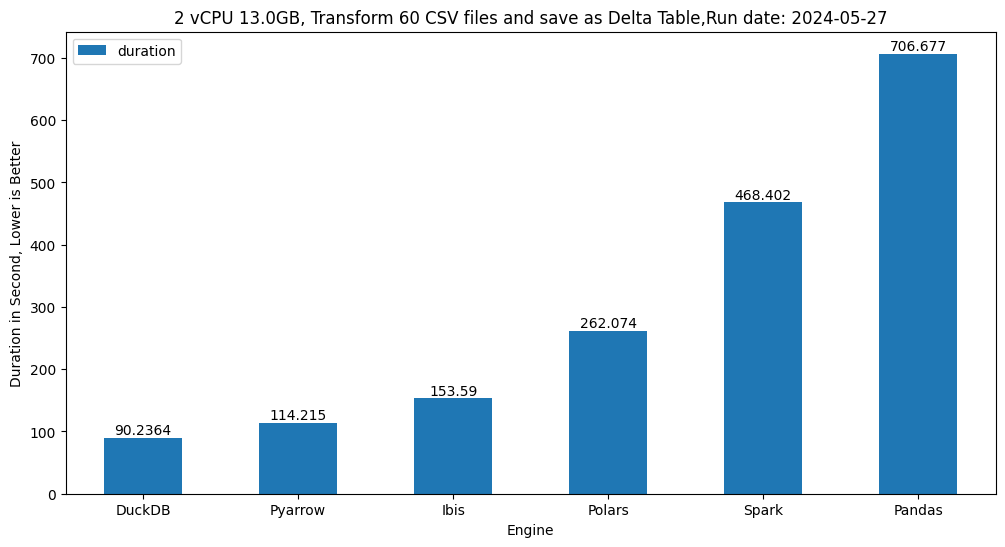

In [23]:
# @title
result = results.groupby(['Engine'])['duration'].sum().reset_index()
result = result.sort_values(by = ['duration'], ascending=[True])
from psutil import *
vCPU = str(cpu_count()) + " vCPU"
mem=round(virtual_memory().total/(1024 * 1024 * 1024),0)
runtime = vCPU+' '+str(mem)+'GB'+ ', Transform '+ str(total_files)+' CSV files and save as Delta Table,Run date: '+ str(time.strftime("%Y-%m-%d"))
ax = result.plot.bar(rot=0,x='Engine',title=runtime,ylabel='Duration in Second, Lower is Better',figsize=(12,6))
for c in ax.containers:
    ax.bar_label(c, label_type='edge')

# Check Size

In [24]:
# @title
#the function read all the tables in the default Lakehouse and save it in a Table Delta_stats, change the url to reflect your destination
import duckdb
import pandas as pd
from deltalake import DeltaTable
import os
from datetime import datetime
from deltalake.writer import write_deltalake
def get_stats(Source,Destination):
    appended_data = []
    List_tables = [ f.name for f in os.scandir(Source) if f.is_dir() ]
    stat_table = os.path.basename(os.path.normpath(Destination))
    if stat_table in List_tables: List_tables.remove(stat_table)
    for tbl in List_tables :
        dt = DeltaTable(Source+ tbl)
        xx= dt.get_add_actions(flatten=True).to_pandas()
        if 'tags.VORDER' in xx.columns:
             vorder =True
        else :
             vorder =False
        deltalog=pd.DataFrame([[tbl,xx['size_bytes'].sum(),vorder]],columns=['tbl','size_bytes','vorder'])
        delta = [Source+tbl + "/" + i for i in dt.files()]
        duckdb.sql(f'from parquet_scan({delta})').to_view(tbl)
        print(tbl)
        df= duckdb.sql(f'''
        with x as (
        select file_name,num_rows,num_row_groups, '{tbl}' as tbl from parquet_file_metadata({delta})
        )
        select x.tbl, file_name,num_rows,num_row_groups, ceil(size_bytes/(1024*1024)) as size,vorder from x
        left join deltalog as y
        on x.tbl=y.tbl
         ''').df()
        appended_data.append(df)
    appended_data = pd.concat(appended_data,ignore_index=True)
    appended_data['timestamp'] = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
    write_deltalake(Destination,appended_data,mode="overwrite",storage_options={"allow_unsafe_rename":"true"})

    dt = DeltaTable(Destination)
    delta = [Destination + "/" + i for i in dt.files()]
    duckdb.sql(f'from parquet_scan({delta})').to_view("xxx")

    duckdb.sql('''
    select tbl,
    sum(num_rows) as total_rows,
    count(*) as num_files,
    sum(num_row_groups) as num_row_group,
    cast(ceil(total_rows/num_row_group) as integer) as Average_row_group,
    min(size) as file_size_MB,
    vorder
    from xxx
    group by all
    order by file_size_MB ASC
    ''').show()
get_stats('/lakehouse/default/Tables/','/lakehouse/default/Files/xx_deltastats')

scada_DuckDB
scada_ibis
scada_Pandas
scada_spark
scada_Polars
scada_Pyarrow
┌───────────────┬────────────┬───────────┬───────────────┬───────────────────┬──────────────┬─────────┐
│      tbl      │ total_rows │ num_files │ num_row_group │ Average_row_group │ file_size_MB │ vorder  │
│    varchar    │   int128   │   int64   │    int128     │       int32       │    double    │ boolean │
├───────────────┼────────────┼───────────┼───────────────┼───────────────────┼──────────────┼─────────┤
│ scada_spark   │    8388240 │        30 │            30 │            279608 │         82.0 │ false   │
│ scada_DuckDB  │    8388240 │         1 │           126 │             66574 │         85.0 │ false   │
│ scada_ibis    │    8388240 │         1 │           126 │             66574 │         85.0 │ false   │
│ scada_Pandas  │    8388240 │         3 │           123 │             68198 │         85.0 │ false   │
│ scada_Pyarrow │    8388240 │         1 │           125 │             67106 │         85.0 